# Heart Disease Prediction

Heart disease is an extremely common medical problem worldwide, [killing more people globally than any other cause](https://www.who.int/news-room/fact-sheets/detail/the-top-10-causes-of-death). One challenge in management of heart disease is detecting it at an early phase so that nonsurgical and even nonmedical interventions such as changes to diet or increased exercise can effectively stop or reverse the course of the disease. An ideal heart disease screener would be fast, accurate, and precise, with the ability provide an effective diagnosis in clinical settings without access to complex and expensive testing equipment or slow laboratory test.

Designing such a screener is, however, beyond the scope of this project. Instead, the goal of this project is to experiment with ten different machine learning models from scikit-learn and determine which maximizes the overall accuracy of the predictions (that is, has the highest probability of predicting correctly) as well as discovering which clinical markers from the [Kaggle heart disease prediction dataset](https://www.kaggle.com/fedesoriano/heart-failure-prediction) appear to be most relevant to whether or not a given patient has heart disease. Using this information, a more advanced classifier building on domain expertise could be built to provide a useful screening tool to assist primary care physicians and cardiologists suspecting heart disease in their patients. To begin with, we load a number of libraries and the input dataset, and look at the first few rows of the latter.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split # For creating training and testing sets
from sklearn.preprocessing import MinMaxScaler # normalizing data

# A whole bunch of classifiers.
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

csv_path = "heart.csv"
heart_disease_base = pd.read_csv(csv_path)

print('This dataset has {} observations.\n'.format(len(heart_disease_base)))

heart_disease_base.head()

This dataset has 918 observations.



,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


We can see that the dataset contains a considerable amount of data. Discounting the HeartDisease column, which is intended to provide ground truth validation for our analysis, there are eleven variables in this dataset, describing 918 observations (that is, patients). As usual, it is worth checking whether the data is complete and lacking any missing values.

In [2]:
are_nas = ""
if not heart_disease_base.isnull().values.any():
    are_nas = "no "
    
print('There are {}null values in the dataset.\n'.format(are_nas))

heart_disease_base.describe()

There are no null values in the dataset.



,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


Fortunately, there are no null or NA values in the dataset...at least, under that name. Looking at the column data presents a somewhat different picture, however. Consulting the documentation, the values for most of the columns look reasonable or at least not obviously wrong to a non-expert (bearing in mind that FastingBS and HeartDisease are booleans encoded as ints), but RestingBP and Cholesterol stand out. Clearly, it is not possible for a living human to have a RestingBP of zero, and a Cholesterol level of zero would also be a life-threatening medical emergency. The more likely explanation is that these were simply default values input in cases where blood pressure or cholesterol were not actually measured. This can be checked by determining the number of observations where values of zero are present for each variable, as well as identifying the number of observations where either value falls into the clinical definitions of hypotension (less than 90 mm Hg, assuming that the data is of systolic pressure; the values do appear to be more consistent with systolic pressure than diastolic pressure) or hypocholesterolemia (less than 160 mg/dL of cholesterol).

In [3]:
num_zero_bp = heart_disease_base.RestingBP.value_counts()[0]
num_zero_ch = heart_disease_base.Cholesterol.value_counts()[0]
num_hypo_bp = len(heart_disease_base.loc[(heart_disease_base['RestingBP'] < 90) & (heart_disease_base['RestingBP'] > 0)])
num_hypo_ch = len(heart_disease_base.loc[(heart_disease_base['Cholesterol'] < 160) & (heart_disease_base['Cholesterol'] > 0)])

print('There are {} observations with zero blood pressure in the dataset.'.format(num_zero_bp))
print('There are {} observations with zero blood cholesterol in the dataset.'.format(num_zero_ch))
print('There are {} observations with low blood pressure in the dataset.'.format(num_hypo_bp))
print('There are {} observations with low blood cholesterol in the dataset'.format(num_hypo_ch))

There are 1 observations with zero blood pressure in the dataset.
There are 172 observations with zero blood cholesterol in the dataset.
There are 1 observations with low blood pressure in the dataset.
There are 25 observations with low blood cholesterol in the dataset


This indicates that missing blood pressure is not a serious problem, with only a single observation missing a blood pressure value. By contrast, missing cholesterol values are a major issue with the datset; 172 observaitons, about 19%, have no cholesterol value provided. Hypotension and hypocholesterolemia do not appear to be common excluding this, with only a single observation of blood pressures below 90 mm Hg other than those obesrvations with a value of zero, and only 25 observations of blood cholesterol below 160 mm/dL. It is worthwhile to look at the subsets that have non-zero but low values in somewhat more detail, however.

In [4]:
heart_disease_base.loc[(heart_disease_base['RestingBP'] < 90) & (heart_disease_base['RestingBP'] > 0)].head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
314,53,M,ASY,80,0,0,Normal,141,Y,2.0,Down,0


The observation that has a low but not-zero blood pressure seems to be normal otherwise, except that it also has missing blood cholesterol values.

In [5]:
heart_disease_base.loc[(heart_disease_base['Cholesterol'] < 160) & (heart_disease_base['Cholesterol'] > 0)].describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000
mean,53.120000,130.520000,132.880000,0.200000,136.120000,0.808000,0.520000
std,12.434227,18.681809,19.946428,0.408248,26.459592,0.931361,0.509902
min,28.000000,92.000000,85.000000,0.000000,94.000000,0.000000,0.000000
25%,44.000000,120.000000,123.000000,0.000000,120.000000,0.000000,0.000000
50%,52.000000,131.000000,139.000000,0.000000,130.000000,0.600000,1.000000
75%,62.000000,140.000000,149.000000,0.000000,146.000000,1.500000,1.000000
max,76.000000,160.000000,159.000000,1.000000,185.000000,3.500000,1.000000


As with the hypotensive observations, the hypocholesterolemic obervations appear to be largely unremarkable leaving aside their unusual blood cholesterol levels. Therefore, we can simply focus on the observations where either blood pressure or cholesterol is zero for data imputing. In the former case, simply imputing the mean value of blood pressure is a reasonable strategy that should not greatly affect our results, as there is only the one observation, but in the latter the large proportion of observations compared to the whole dataset means that there could be a bias introduced by this approach. However, experimenting with different methods of dealing with missing data is beyond the scope of this work, and so is only mentioned in case there is interest in follow up work. First, we will add a column identifying imputed cholesterol values in the form of a boolean ("True" means there was an imputation, "False" means that there was not):

In [6]:
# We want to keep a pristine copy of the base dataset.
heart_disease_cleaned = heart_disease_base.copy()

heart_disease_cleaned['invalid_cholesterol'] = False
heart_disease_cleaned.loc[heart_disease_cleaned.Cholesterol == 0, 'invalid_cholesterol'] = True

zero_ch = heart_disease_cleaned.loc[heart_disease_cleaned.Cholesterol == 0]
non_zero_ch = heart_disease_cleaned.loc[heart_disease_cleaned.Cholesterol > 0]

num_zero_false = len(zero_ch['invalid_cholesterol']) - zero_ch['invalid_cholesterol'].sum()
num_non_zero_true = non_zero_ch['invalid_cholesterol'].sum()

print('There are {} observations with zero blood cholesterol that have a False value for invalid_cholesterol.'.format(num_zero_false))
print('There are {} observations with non-zero blood cholesterol that have a True value for invalid_cholesterol.'.format(num_non_zero_true))

There are 0 observations with zero blood cholesterol that have a False value for invalid_cholesterol.
There are 0 observations with non-zero blood cholesterol that have a True value for invalid_cholesterol.


Next we will calculate the mean blood pressure and mean cholesterol excluding the zero value observations, then impute those into the observations that have zero value.

In [7]:
cholesterol_mean = heart_disease_cleaned.loc[heart_disease_cleaned.invalid_cholesterol == False, 'Cholesterol'].mean()
heart_disease_cleaned.loc[heart_disease_cleaned.invalid_cholesterol == True, 'Cholesterol'] = cholesterol_mean

bp_mean = heart_disease_cleaned.loc[heart_disease_cleaned.RestingBP != 0, 'RestingBP'].mean()
heart_disease_cleaned.loc[heart_disease_cleaned.RestingBP == 0, 'RestingBP'] = bp_mean

cholesterol_template = "The pre-imputation value of the mean blood cholesterol (excluding zero values) was {},and the post-imputation value was {}."
bp_template = "The pre-imputation value of the mean blood pressure (excluding zero values) was {}, and the post-imputation value was {}."

print(cholesterol_template.format(cholesterol_mean, heart_disease_cleaned['Cholesterol'].mean()))
print(bp_template.format(bp_mean, heart_disease_cleaned['RestingBP'].mean()))

The pre-imputation value of the mean blood cholesterol (excluding zero values) was 244.6353887399464,and the post-imputation value was 244.63538873994625.
The pre-imputation value of the mean blood pressure (excluding zero values) was 132.54089422028352, and the post-imputation value was 132.54089422028355.


And a quick inspection of the cells that had a zero value shows that they are now filled by the mean value:

In [8]:
heart_disease_cleaned[heart_disease_cleaned['invalid_cholesterol'] == True].head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease,invalid_cholesterol
293,65,M,ASY,115.0,244.635389,0,Normal,93,Y,0.0,Flat,1,True
294,32,M,TA,95.0,244.635389,1,Normal,127,N,0.7,Up,1,True
295,61,M,ASY,105.0,244.635389,1,Normal,110,Y,1.5,Up,1,True
296,50,M,ASY,145.0,244.635389,1,Normal,139,Y,0.7,Flat,1,True
297,57,M,ASY,110.0,244.635389,1,ST,131,Y,1.4,Up,1,True


Besides imputing this data, the dataset also includes several columns that store boolean data according to the documentation, but do so without using the boolean type. For FastingBS, a '0' is used to indicate a fasting blood sugar level below 120 mg/dL and a '1' is used to indicate a greater level; for ExerciseAngina a 'Y' is used to indicate that angina (chest pain) was observed during exercise; and for HeartDisease, '0' is used to indicate that heart disease was not found and '1' to indicate that it was. All of these can quickly be converted to booleans. First, look at the current head:

In [9]:
heart_disease_cleaned.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease,invalid_cholesterol
0,40,M,ATA,140.0,289.0,0,Normal,172,N,0.0,Up,0,False
1,49,F,NAP,160.0,180.0,0,Normal,156,N,1.0,Flat,1,False
2,37,M,ATA,130.0,283.0,0,ST,98,N,0.0,Up,0,False
3,48,F,ASY,138.0,214.0,0,Normal,108,Y,1.5,Flat,1,False
4,54,M,NAP,150.0,195.0,0,Normal,122,N,0.0,Up,0,False


Then, convert the variables to booleans and verify that they correspond properly:

In [10]:
heart_disease_cleaned['FastingBS'] = heart_disease_cleaned['FastingBS'].astype(bool)
heart_disease_cleaned['ExerciseAngina'] = heart_disease_cleaned['ExerciseAngina'].map({'Y': True, 'N': False})
heart_disease_cleaned['HeartDisease'] = heart_disease_cleaned['HeartDisease'].astype(bool)

heart_disease_cleaned.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease,invalid_cholesterol
0,40,M,ATA,140.0,289.0,False,Normal,172,False,0.0,Up,False,False
1,49,F,NAP,160.0,180.0,False,Normal,156,False,1.0,Flat,True,False
2,37,M,ATA,130.0,283.0,False,ST,98,False,0.0,Up,False,False
3,48,F,ASY,138.0,214.0,False,Normal,108,True,1.5,Flat,True,False
4,54,M,NAP,150.0,195.0,False,Normal,122,False,0.0,Up,False,False


The next issue that needs to be handled is the categorical information present in the Sex, ChestPainType, RestingECG, and and ST_Slope variables. Each of these is stored as a string holding a limited range of possible values, which many classification models cannot properly engage with. A more useful way of encoding this information would be to create new columns corresponding to each of the possibile categorical values and then assign a True or False value itself corresponding to the original category of the observation, which is called "one hot" encoding. For example, a patient with a ChestPainType of ATA, Atypical Angina, would have a True value in that column and a False value in the columns corresponding to TA, NAP, and ASY (the other possible values). We can quickly convert these as well, then check that the output is fine.

In [11]:
heart_disease_cleaned['male'] = heart_disease_cleaned['Sex'].map({'M': True, 'F': False})
heart_disease_cleaned['female'] = heart_disease_cleaned['Sex'].map({'M': False, 'F': True})

heart_disease_cleaned['ta_chest_pain'] = heart_disease_cleaned['ChestPainType'].map({'TA': True, 'ATA': False, 'NAP': False, 'ASY': False})
heart_disease_cleaned['ata_chest_pain'] = heart_disease_cleaned['ChestPainType'].map({'TA': False, 'ATA': True, 'NAP': False, 'ASY': False})
heart_disease_cleaned['nap_chest_pain'] = heart_disease_cleaned['ChestPainType'].map({'TA': False, 'ATA': False, 'NAP': True, 'ASY': False})
heart_disease_cleaned['asy_chest_pain'] = heart_disease_cleaned['ChestPainType'].map({'TA': False, 'ATA': False, 'NAP': False, 'ASY': True})

heart_disease_cleaned['normal_ecg'] = heart_disease_cleaned['RestingECG'].map({'Normal': True, 'ST': False, 'LVH': False})
heart_disease_cleaned['st_ecg'] = heart_disease_cleaned['RestingECG'].map({'Normal': False, 'ST': True, 'LVH': False})
heart_disease_cleaned['lvh_ecg'] = heart_disease_cleaned['RestingECG'].map({'Normal': False, 'ST': False, 'LVH': True})

heart_disease_cleaned['up_st'] = heart_disease_cleaned['ST_Slope'].map({'Up': True, 'Flat': False, 'Down': False})
heart_disease_cleaned['flat_st'] = heart_disease_cleaned['ST_Slope'].map({'Up': False, 'Flat': True, 'Down': False})
heart_disease_cleaned['down_st'] = heart_disease_cleaned['ST_Slope'].map({'Up': False, 'Flat': False, 'Down': True})

heart_disease_cleaned.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,...,ta_chest_pain,ata_chest_pain,nap_chest_pain,asy_chest_pain,normal_ecg,st_ecg,lvh_ecg,up_st,flat_st,down_st
0,40,M,ATA,140.0,289.0,False,Normal,172,False,0.0,...,False,True,False,False,True,False,False,True,False,False
1,49,F,NAP,160.0,180.0,False,Normal,156,False,1.0,...,False,False,True,False,True,False,False,False,True,False
2,37,M,ATA,130.0,283.0,False,ST,98,False,0.0,...,False,True,False,False,False,True,False,True,False,False
3,48,F,ASY,138.0,214.0,False,Normal,108,True,1.5,...,False,False,False,True,True,False,False,False,True,False
4,54,M,NAP,150.0,195.0,False,Normal,122,False,0.0,...,False,False,True,False,True,False,False,True,False,False


That having been done, we can finish up the basic cleaning process by renaming the column names to be consistent with each other and dropping the categorical columns we reencoded in one hot form.

In [12]:
name_map = {
    'Age': 'age',
    'Sex': 'sex',
    'RestingBP': 'resting_bp',
    'Cholesterol': 'cholesterol',
    'FastingBS': 'fasting_bs',
    'MaxHR': 'max_hr',
    'ExerciseAngina': 'exercise_angina',
    'Oldpeak': 'oldpeak',
    'HeartDisease': 'heart_disease'
}

heart_disease_cleaned.rename(columns=name_map, inplace=True)

heart_disease_cleaned.drop(['ChestPainType'], axis=1, inplace=True)
heart_disease_cleaned.drop(['RestingECG'], axis=1, inplace=True)
heart_disease_cleaned.drop(['ST_Slope'], axis=1, inplace=True)
    
heart_disease_cleaned.head()

,age,sex,resting_bp,cholesterol,fasting_bs,max_hr,exercise_angina,oldpeak,heart_disease,invalid_cholesterol,...,ta_chest_pain,ata_chest_pain,nap_chest_pain,asy_chest_pain,normal_ecg,st_ecg,lvh_ecg,up_st,flat_st,down_st
0,40,M,140.0,289.0,False,172,False,0.0,False,False,...,False,True,False,False,True,False,False,True,False,False
1,49,F,160.0,180.0,False,156,False,1.0,True,False,...,False,False,True,False,True,False,False,False,True,False
2,37,M,130.0,283.0,False,98,False,0.0,False,False,...,False,True,False,False,False,True,False,True,False,False
3,48,F,138.0,214.0,False,108,True,1.5,True,False,...,False,False,False,True,True,False,False,False,True,False
4,54,M,150.0,195.0,False,122,False,0.0,False,False,...,False,False,True,False,True,False,False,True,False,False


Now we can move on to the next step, setting up training and testing sets to run different classifiers on. To select our sets, we will use stratified sampling based on age, since we know independently that age is strongly correlated with heart disease and so if our training or test sets have very different distributions of age than our source set this could cause our models to systematically err. First we look at the distribution of age in our source data:

(array([ 38., 140., 209., 310., 177.,  44.]),
 array([28.        , 36.16666667, 44.33333333, 52.5       , 60.66666667,
        68.83333333, 77.        ]),
 <BarContainer object of 6 artists>)

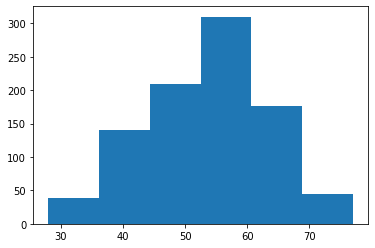

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.hist(heart_disease_cleaned['age'], bins=6)

As expected, this is skewed towards older patients, with younger ones relatively underrepresented. There is a peak in the late 50s and early 60s, with a fairly large proportion in the earlier 50s and late 40s as well. This can be seen more easily if we instead categorize patients by their rounded age (i.e., patients from 25-34 are "30," patients from 35 to 44 are "40," and so on and so forth):

(array([ 21., 175., 275., 365.,  82.]),
 array([3., 4., 5., 6., 7., 8.]),
 <BarContainer object of 5 artists>)

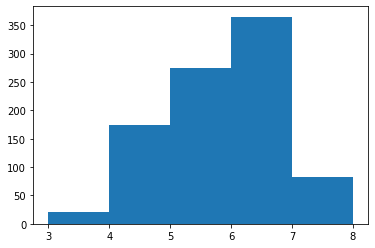

In [14]:
heart_disease_cleaned['age_cat'] = np.round(heart_disease_cleaned['age'] / 10.0)
plt.hist(heart_disease_cleaned['age_cat'], bins = 5)

Therefore, when selecting our training and test datasets, we want to ensure that the distribution of ages in both approximately matches the distribution in the original dataset, that is the proportion of patients in each age category is about the same.

In [15]:
# A module for doing stratified selections
from sklearn.model_selection import StratifiedShuffleSplit

# Setting a seed (random_state = 39) means our results are repeatable. Change this if you like.
split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 39)
for train_index, test_index in split.split(heart_disease_cleaned, heart_disease_cleaned["age_cat"]):
    strat_train_set = heart_disease_cleaned.loc[train_index]
    strat_test_set = heart_disease_cleaned.loc[test_index]

# The point of this is to check that the proportions of each age group and sex in the training and test sets is similar to that in the source set.
original_age_ratios = heart_disease_cleaned['age_cat'].value_counts() / len(heart_disease_cleaned)
original_sex_ratios = heart_disease_cleaned['sex'].value_counts() / len(heart_disease_cleaned)

train_age_ratios = strat_train_set['age_cat'].value_counts() / len(strat_train_set)
train_sex_ratios = strat_train_set['sex'].value_counts() / len(strat_train_set)

test_age_ratios = strat_test_set['age_cat'].value_counts() / len(strat_test_set)
test_sex_ratios = strat_test_set['sex'].value_counts() / len(strat_test_set)

print('The ratios of the proportion of observations in each age category in the training set to the whole data set are')
print(train_age_ratios/original_age_ratios)
print('\nValues < 1 indicate relatively fewer observations in that category in the training set than in the original set, whereas values > 1 indicate relatively more.')
print('\nThe ratios of the proportion of observations in each sex category in the training set to the whole data set are')
print(train_sex_ratios/original_sex_ratios)
print('\nFor the test set, the ratios are')
print(test_age_ratios/original_age_ratios)
print('And')
print(test_sex_ratios/original_sex_ratios)

The ratios of the proportion of observations in each age category in the training set to the whole data set are
6.0    1.000545
5.0    1.000545
4.0    1.000545
7.0    1.000545
3.0    1.012456
8.0    0.893344
Name: age_cat, dtype: float64

Values < 1 indicate relatively fewer observations in that category in the training set than in the original set, whereas values > 1 indicate relatively more.

The ratios of the proportion of observations in each sex category in the training set to the whole data set are
M    1.000545
F    0.997953
Name: sex, dtype: float64

For the test set, the ratios are
6.0    0.997826
5.0    0.997826
4.0    0.997826
7.0    0.997826
3.0    0.950311
8.0    1.425466
Name: age_cat, dtype: float64
And
M    0.997826
F    1.008166
Name: sex, dtype: float64


Overall, this indicates a fairly good split, with the caveat that the 8.0 age category is drastically overrepresented in the test set. However, careful examination of the previous chart of the age category suggests that there might not be that many values in it, which can be easily checked:

In [16]:
print('The number of observations in the highest age category is ' + str(len(heart_disease_cleaned[heart_disease_cleaned['age_cat'] == 8.0])) + '.')

The number of observations in the highest age category is 7.


Indeed, with only 7 observations of patients 75-85 years old, this category is very small and practically irrelevant. It is also not difficult to see how a random selection might easily lead to an (apparently) highly skewed ratio of entries in that category relative to the original source. Merely selecting two observations with that value of age_cat for the test dataset would in fact produce a result similar to the one actually obtained.

With the training and test sets defined, there is just one more data cleaning task to do, normalizing the data. Many (though not all) types of classifier are sensitive to the magnitude of input data, and ours varies by a factor of about 100 between the RestingBP and Cholesterol columns and the Oldpeak and boolean columns. By normalizing this data we can put them on a level plain and more fairly compare different classifiers.

In [17]:
# Now the age_cat and sex columns aren't useful, so we get rid of them.
for dataset in (heart_disease_cleaned, strat_train_set, strat_test_set):
    dataset.drop(['age_cat'], axis=1, inplace=True)
    dataset.drop(['sex'], axis=1, inplace=True)

In [18]:
# And now we can normalize them.

norm = MinMaxScaler().fit(strat_train_set)

norm_train_set = pd.DataFrame(norm.transform(strat_train_set), columns=strat_train_set.columns, index=strat_train_set.index)
norm_test_set = pd.DataFrame(norm.transform(strat_test_set), columns=strat_test_set.columns, index=strat_test_set.index)

With the data preparation complete, we can now start doing some preliminary, informal analysis of the available data. The first thing to do is to look at the correlation matrices of the various columns of our data, for both the unnormalized and normalized data. This serves as both a sanity check on the normalization (since this is merely rescaling the data, the correlations between different variables should remain the same) and provides a preliminary feeling of what variables a classifier should be looking at more or less closely. After all, if two variables (for example, blood pressure and heart disease) are strongly correlated, then this means that measurements of one should be able to predict the other to a good extent.

In [19]:
# First split the dataframes into the label and the data--we are mainly interested in correlations between the data and the label.
# Plus, we need the separate the data and label for training later anyway.

strat_train_label = strat_train_set['heart_disease']
norm_train_label = norm_train_set['heart_disease']

strat_train_data = strat_train_set.loc[:, (strat_train_set.columns != 'heart_disease') & (strat_train_set.columns != 'invalid_cholesterol')]
norm_train_data = norm_train_set.loc[:, (norm_train_set.columns != 'heart_disease') & (norm_train_set.columns != 'invalid_cholesterol')]

unscaled_corrs = strat_train_data.corrwith(strat_train_label)
scaled_corrs = norm_train_data.corrwith(norm_train_label)

In [20]:
unscaled_corrs.sort_values(ascending=False)

flat_st            0.550854
asy_chest_pain     0.523488
exercise_angina    0.507783
oldpeak            0.406019
male               0.292173
age                0.283755
fasting_bs         0.253235
resting_bp         0.117714
down_st            0.117454
st_ecg             0.113649
cholesterol        0.098922
lvh_ecg            0.032370
ta_chest_pain     -0.005672
normal_ecg        -0.118570
nap_chest_pain    -0.241006
female            -0.292173
ata_chest_pain    -0.403090
max_hr            -0.403684
up_st             -0.612334
dtype: float64

In [21]:
scaled_corrs.sort_values(ascending=False)

flat_st            0.550854
asy_chest_pain     0.523488
exercise_angina    0.507783
oldpeak            0.406019
male               0.292173
age                0.283755
fasting_bs         0.253235
resting_bp         0.117714
down_st            0.117454
st_ecg             0.113649
cholesterol        0.098922
lvh_ecg            0.032370
ta_chest_pain     -0.005672
normal_ecg        -0.118570
nap_chest_pain    -0.241006
female            -0.292173
ata_chest_pain    -0.403090
max_hr            -0.403684
up_st             -0.612334
dtype: float64

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:59: UserWarning: FixedFormatter should only be used together with FixedLocator


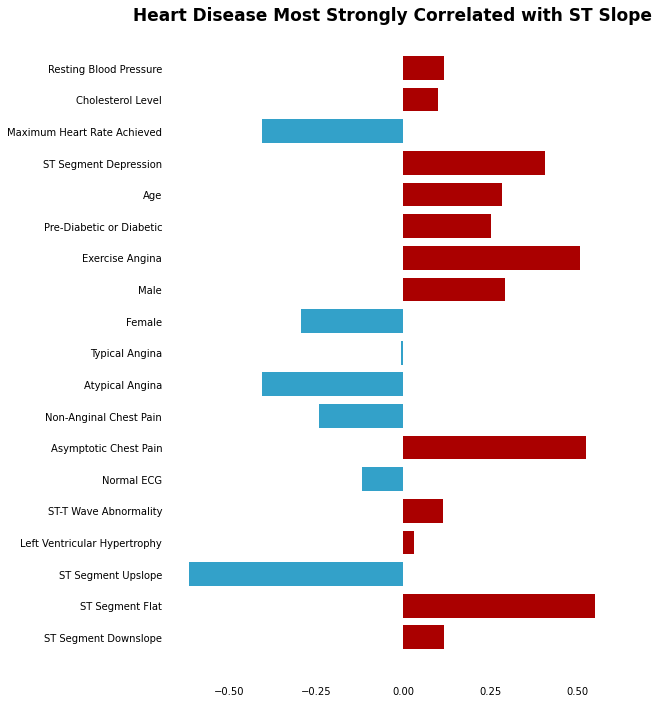

In [22]:
positive_corrs = scaled_corrs >= 0
corr_color_map = positive_corrs.map({True:'#AA0000', False:'#33A1C9'})

corr_label_dict = {
    'down_st': 'ST Segment Downslope',
    'flat_st': 'ST Segment Flat',
    'up_st': 'ST Segment Upslope',
    'lvh_ecg': 'Left Ventricular Hypertrophy',
    'st_ecg': 'ST-T Wave Abnormality',
    'normal_ecg': 'Normal ECG',
    'asy_chest_pain': 'Asymptotic Chest Pain',
    'nap_chest_pain': 'Non-Anginal Chest Pain',
    'ata_chest_pain': 'Atypical Angina',
    'ta_chest_pain': 'Typical Angina',
    'female': 'Female',
    'male': 'Male',
    'oldpeak': 'ST Segment Depression',
    'exercise_angina': 'Exercise Angina',
    'max_hr': 'Maximum Heart Rate Achieved',
    'fasting_bs': 'Pre-Diabetic or Diabetic',
    'cholesterol': 'Cholesterol Level',
    'resting_bp': 'Resting Blood Pressure',
    'age': 'Age'
}

cat_corrs = scaled_corrs.loc[['down_st', 'flat_st', 'up_st', 'lvh_ecg', 'st_ecg', 'normal_ecg', 'asy_chest_pain', 'nap_chest_pain',
                                    'ata_chest_pain', 'ta_chest_pain', 'female', 'male', 'exercise_angina', 'fasting_bs', 'age']]
cont_corrs = scaled_corrs.loc[['oldpeak', 'max_hr', 'cholesterol', 'resting_bp']]

positive_cat_corrs = cat_corrs >= 0
cat_color_map = positive_cat_corrs.map({True:'#AA0000', False:'#33A1C9'})

positive_cont_corrs = cont_corrs >= 0
cont_color_map = positive_cont_corrs.map({True:'#AA0000', False:'#33A1C9'})

fig, ax = plt.subplots(figsize=(8, 12))

ax.barh(cat_corrs.index, cat_corrs, height=0.75, color=cat_color_map)
ax.barh(cont_corrs.index, cont_corrs, height=0.75, color=cont_color_map)

for location in ['left', 'right', 'bottom', 'top']:
    ax.spines[location].set_visible(False)
    
ax.tick_params(bottom=False, left=False)

ax.set_xticks([-0.5, -0.25, 0, 0.25, 0.5])

ax.set_title("Heart Disease Most Strongly Correlated with ST Slope", size = 17, weight='bold')

plt.draw()

tick_coords = ax.get_yticks()
new_labels = []
original_labels = ax.get_yticklabels()

for n in tick_coords:
    new_labels.append(plt.Text(0, n, corr_label_dict[original_labels[n].get_text()]))
    
ax.set_yticklabels(new_labels)

plt.draw()

Examining these results, they firstly confirm that the normalizer is at least not obviously malfunctioning: the magnitudes and signs of the correlations in both the normalized and raw data are the same, as expected. Secondly, and more interestingly, they show certain patterns in which clinical signs are predictive of heart disease, which are predictive of not having heart disease, and which are relatively irrelevant. For example, the slope of the ST segment of the ECG appears to be the most predictive single variable for whether a patient has heart disease or not, with flat or downsloping segments (especially flat ones) being positively associated with heart disease. Other key variables include the presence (or absence) of exercise-related angina or asymptotic chest pain, or the value of the Oldpeak variable, that is the depression of the ST segment below the baseline. Surprisingly, the *absence* of chest pain is associated with a heart disease diagnosis, but the presence of chest pain, other than typical angina, is instead correlated with *not* being diagnosed with heart disease.

Now we can begin looking at the different classifiers themselves. I have selected ten diferent classifiers, each of which takes a different approach to try to divide the dataset into patients that have heart disease and patients who do not have heart disease. The first, the multi-layer perceptron classifier, is a classical neural network algorithm that uses one or more "hidden" layers of neurons (between the input and output levels) to build a non-linear function mapping the input values into the output.[1](https://scikit-learn.org/stable/modules/neural_networks_supervised.html)

The second, the k-neighbors classifier, is closely related to the k-nearest-neighbors clustering algorithm, and functions by finding the nearest observations to a given observation in a higher-dimensional space created by the data variables. Specifically, it measures the Euclidean distances between the point to be classified and its k nearest neighbors (hence the name) in this higher-dimensional space. Whichever class has more neighbors in this set then "wins," and the point to be classified is assigned to it.[2](https://scikit-learn.org/stable/modules/neighbors.html#classification)

The third, the support vector classifier, works by constructing hyperplanes within the higher-dimension space created by the data variables that separate the data into two (or more, but in this case two) subsets. The "support vectors" of the name are the set of points that determine the position of the hyperplane or hyperplanes; generally speaking, the optimal hyperplane will be the one that maximizes the distance between the plane and the nearest points in each class, and the support vectors are then exactly these nearest points.[3](https://scikit-learn.org/stable/modules/svm.html#svm-mathematical-formulation)

The fourth, the Gaussian process classifier, is based on building a Gaussian process, essentially a version of the Gaussian distribution extended to the case of the multivariate distribution of infinite number of variables, which is then transformed by using a quantile function to obtain a probability. In turn, this can be used to determine the class of an observation, especially in a binary case, and makes them relatively easily to understand statistically. For this case, as well, the relatively small number of observations and variables means that their performance issues are mitigated.[4](https://scikit-learn.org/stable/modules/gaussian_process.html)

The fifth, the decision tree classifier, was explained in the course, but works by attempting to find combinations of variable values that divide the data space most efficiently into the target classes (in this case, two classes). In practice, it is usually not possible to completely separate the data into the target classes with a single rule, so each rule is instead used to separate the subspaces into further subspaces that are increasingly pure examples of a given target class. Ideally, the decision tree will come up with rules that can be used to divide the space into a set of pure subspaces that only contain data corresponding to one of the target classes, but in practice this usually requires an excessive tree depth and leads to overfitting, so instead the eventual subspaces only tend to be mostly pure.[5](https://scikit-learn.org/stable/modules/tree.html#tree)

The sixth, the random forest classifier, builds on the decision tree classifier to help mitigate some of its flaws. Instead of building a single decision tree on all of the data, it builds multiple decision trees on randomized subsets of the training data (hence "random forest") and then presents their average or ensemble result as the output for test data. This reduces the risk of overfitting and improves overall performance, making this a powerful model for classification predicions.[6](https://scikit-learn.org/stable/modules/ensemble.html#forest)

The seventh, the AdaBoost classifier, is similar to the random forest classifier, in that it is based on combining the results from many weak or limited models in order to provide a stronger and more accurate prediction. The difference is that instead of merely running these models in parallel on subsets of the data and averaging them together, it uses a weighted average of models fitted on modified versions of the data. These modifications are determined iteratively and conist of weighting data that the models find difficult to predict more heavily than data that they predict easily, in effect giving a louder "voice" to models that can predict harder cases.[7](https://scikit-learn.org/stable/modules/ensemble.html#adaboost)

The eighth, the Gaussian naïve Bayes model, functions by using Bayes' theorem, which permits the inversion of conditional probabilities (i.e., it allows the use of the probability of B given A to calculate the probability of A given B). The "naïveté" of the model comes from it assuming that the probability of the target feature (in this case whether or not a patient has heart disease) as a function of a given variable (for example, the blood pressure) is independent of the probability of the target feature as a function of a different variable, for example whether or not the patient has exercise angina. This assumption simplifies the mathematics considerably, but there is usually not any reason to believe that this is the case for a real model. Finally, the "Gaussian" part merely means that a Gaussian distribution is assumed for the conditional probabilities, again something that there is no real reason to believe is true but which simplifies the calculations. The result is a rather simple model, but simplicity can sometimes be a strength.[8](https://scikit-learn.org/stable/modules/naive_bayes.html)

The ninth and tenth, the linear discriminant and quadratic discriminant models, respectively, are closely related, and related to the Gaussian naïve Bayes model, in that they also rely on Bayes' theorem to calculate the probability of a given point being in the relevant class. They differ from the Gaussian naïve Bayes model primarily in that they do not assume that the various probabilities of interest are independent, and they differ from each other mainly in that the prior distribution of the linear discriminant model assumes the there is a single covariance matrix for each class (in this case, no heart disease and heart disease), while in the quadratic model they are permitted to have different covariance matrices. The result is that the linear model can only find linear separation boundaries while the quadratic model can find quadratic ones.[9](https://scikit-learn.org/stable/modules/lda_qda.html#lda-qda)

This by no means exhausts the universe of possible classifiers, however I judged that running a substantially larger number of classifiers would increase the complexity and resource consumption of this notebook without much further value. Looking at ten sometimes very different models and comparing their accuracy should be very enlightening as to the relative value of optimizing the model for a given classification problem and provide guidance on which approaches to take for a follow-up study.

In [23]:
# Seeds were randomly selected to provide reproducability. Feel free to change them if you like!
mlp_predictor = MLPClassifier(random_state = 91, max_iter = 1650).fit(norm_train_data, norm_train_label) #Iter value set experimentally to allow convergence.
knc_predictor = KNeighborsClassifier().fit(norm_train_data, norm_train_label)
svc_predictor = SVC().fit(norm_train_data, norm_train_label)
gpc_predictor = GaussianProcessClassifier(random_state = 78).fit(norm_train_data, norm_train_label)
dtc_predictor = DecisionTreeClassifier(random_state = 86).fit(norm_train_data, norm_train_label)
rfc_predictor = RandomForestClassifier(random_state = 31).fit(norm_train_data, norm_train_label)
abc_predictor = AdaBoostClassifier(random_state = 68).fit(norm_train_data, norm_train_label)
gnb_predictor = GaussianNB().fit(norm_train_data, norm_train_label)
lda_predictor = LinearDiscriminantAnalysis().fit(norm_train_data, norm_train_label)
qda_predictor = QuadraticDiscriminantAnalysis().fit(norm_train_data, norm_train_label)

/opt/conda/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


In [24]:
# Prepare test data for, well, testing
norm_test_label = norm_test_set['heart_disease']
norm_test_data = norm_test_set.loc[:, (norm_test_set.columns != 'heart_disease') & (norm_test_set.columns != 'invalid_cholesterol')]

predictors = [
    mlp_predictor,
    knc_predictor,
    svc_predictor,
    gpc_predictor,
    dtc_predictor,
    rfc_predictor,
    abc_predictor,
    gnb_predictor,
    lda_predictor,
    qda_predictor
]

predictor_names = [
    'MLP',
    'KNC',
    'SVC',
    'GPC',
    'DTC',
    'RFC',
    'ABC',
    'GNB',
    'LDA',
    'QDA'
]

scores = []

for predictor in predictors:
    scores.append(predictor.score(norm_test_data, norm_test_label))
    
series_scores = pd.Series(scores, index = predictor_names)

series_scores.sort_values()

DTC    0.782609
KNC    0.793478
QDA    0.798913
GPC    0.815217
MLP    0.820652
ABC    0.831522
SVC    0.836957
LDA    0.836957
GNB    0.853261
RFC    0.858696
dtype: float64

[Text(0, 0.0, '0.0%'), Text(0, 0.4, '40.0%'), Text(0, 0.8, '80.0%')]

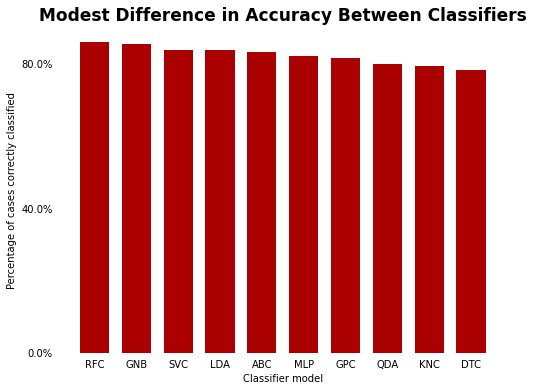

In [25]:
fig, ax = plt.subplots(figsize=(8, 6))

series_scores.sort_values(inplace=True, ascending=False)

ax.bar(series_scores.index, series_scores, width=0.7, color='#AA0000')

for location in ['left', 'right', 'bottom', 'top']:
    ax.spines[location].set_visible(False)
    
ax.tick_params(bottom=False, left=False)

ax.set_yticks([0.0, 0.4, 0.8])

ax.set_title('Modest Difference in Accuracy Between Classifiers', size = 17, weight='bold')

plt.ylabel('Percentage of cases correctly classified')
plt.xlabel('Classifier model')

plt.draw()

tick_coords = ax.get_yticks()
new_labels = []
original_labels = ax.get_yticklabels()

for n in tick_coords:
    new_labels.append(plt.Text(0, n, str(n * 100) + '%'))
    
ax.set_yticklabels(new_labels)

A quick perusal of the scores shows that the best-performing predictors, both with about 85% accuracy, were the Gaussian naïve Bayes model and the random forest classifier. In the latter case this is perhaps not surprising, since the random forest model is known to be particularly powerful, but it is somewhat surprising that a relatively simple naïve Bayes model should outperform nearly all other approaches. It is even more surprising that it worked so well given that there is no reason to expect many of the values in fact follow Gaussian distributions, one of the key assumptions of Gaussian naïve Bayes. However, naïve Bayes is known for being more accurate that would appear likely at first glance, so perhaps this itself should have been expected. By contrast, the least accurate models, with accuracies of about 78-79%, were the ordinary decision tree classifier, the k-neighbors model, and the quadratic discriminant analysis classifier. In the first case this is not surprising since decision trees are known for overfitting and so tend to generalize poorly, but in the others the cause is less obvious, and it is not clear to me why they perform so badly. Particularly surprising is that quadratic analysis performed noticeably worse than the linear analysis, despite having a freer model.

In any case, the actual demonstrated accuracy of all of the models tested, with these default hyperparameter settings, is clearly far too low to be useful in a clinical setting. Even an 85% accuracy means that in 15% of cases, or fifteen out of every hundred patients, the model incorrectly predicts the label, that is either predicts the patient has heart disease when they do not or predicts that they do not have heart disease when they in fact do. Since a diagnosis one way or the other can have life-ending consequences (particularly in the case of a false negative) and given the high prevalance of heart disease in the modern world, such a low accuracy could lead to potentially millions of mistaken diagnoses, thousands of unnecessary deaths, and millions or billions of dollars worth of unnecessary and invasive diagnostic procedures. Clearly, a much higher accuracy would be needed before clinical deployment could take place.

Given the naïve and simple methodology used in this analysis, significant improvements are surely possible. Other models could be tested, which might provide some improvement, but more significantly very little effort was made in this analysis to optimize either data features or model hyperparameters. The features used were largely those of the source dataset, merely modified to make them more usable by machine learning models, and none of the model hyperparameters were changed except to set random seeds on applicable models for reproducability reasons and to increase the number of iterations for the multi-layer perceptron to ensure that it successfully converged. Thoroughly exploring the hyperparameter space and engaging in feature engineering to optimize the input features might lead to significant improvements in accuracy and so create a clinically useful system instead of a mere curiosity. However, doing so is outside of the scope of this project, and would be more appropriate for a follow-on project.